# Animating Convolutions

We've been talking about [convolutions](http://en.wikipedia.org/wiki/Convolution) in my mathematical physics class, and I thought some animations would help. Surprisingly, I couldn't find a great example on the web. I did find what looks like some nice matlab code at [Swarthmore](http://lpsa.swarthmore.edu/Convolution/Convolution3.html)[1], and the wikipedia page linked above has some nice animations with matlab source, but I don't have matlab. I probably spent more time looking for a pre-existing matplotlib animation than it took me to cook one up[2].

Mathematically, the [convolution] of two functions $f$ and $g$ is defined as

$f \ast g = \int_{-\infty}^{\infty} f(\tau)g(t-\tau)d\tau$

Note that the integration $d\tau$ gives us back a function of $t$, and that we can think of a convolution as "sliding" one function across the other. In fact, ["A Student's Guide to Fourier Transforms"](http://books.google.com/books/about/A_Student_s_Guide_to_Fourier_Transforms.html?id=_T99VW0ARfkC) by J.F. James (one of my favorite books, although I own the 1995 edition) has the explanation I like to use, defining things in terms of a signal and an instrument function. You can find good enough explanations in those places (and in others) that I'll just point you elsewhere instead of going through the math/intuition here. Instead, I want to make some animations.


[1] Most uninspired frisbee cheer from my college career: "Swat, Swat, we play you a lot. Go Swat!"

So, first of all, let's handle our standard imports

In [10]:
import numpy as np
from numpy import pi, linspace, ones_like, arange, sin, cos, zeros_like, abs
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

import ipywidgets as widgets
from ipywidgets import interact, fixed

And now let's define a bunch of shapes that we'll want to convolve. I'll calculate the convolution numerically, so I'll set up the total number of points (`nx`) here. I'll also decide that we're going to plot the convolution from $-3\pi$ to $3\pi$ (`fullx`) and each of the functions across a smaller domain $-\pi$ to $\pi$ (`subx`) that slides across the full domain. You can add more function just by adding them to the `Shapes` dictionary. Later on, we'll use the dictionary keys to make dropdown menus and plot legends.[2]

[2] Note to self: I may want to add a filled region with fill_between, and Jake Vanderplas tells me how to animate such a thing [here](http://matplotlib.1069221.n5.nabble.com/animation-of-a-fill-between-region-td42814.html)

In [2]:
nx = 100
fullx = linspace(-3*pi, 3*pi, 3*nx+1)
subx = linspace(-pi, pi, nx+1)
dx = subx[1]-subx[0]
Shapes = {}

Shapes['x'] = subx
Shapes['x2'] = subx**2
Shapes['bigbox'] = ones_like(subx)
Shapes['sin(.5x)'] = sin(0.5*subx+np.pi/2)
Shapes['sin'] = sin(subx)
Shapes['cos'] = cos(subx)

To see what that looks like, let's plot a one:

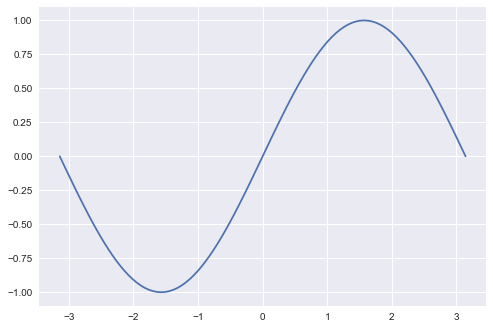

In [3]:
plt.plot(subx,Shapes['sin'])
plt.show()

Based on those, we can make some more

In [4]:
Shapes['sin(2x)'] = sin(2*subx)
Shapes['sin(5x)'] = sin(5*subx)
Shapes['gaussian'] = signal.gaussian(subx.shape[0],std=int(subx.shape[0]/10))

Shapes['smallbox'] = zeros_like(subx)
Shapes['smallbox'][int(Shapes['smallbox'].shape[0]/4):int(Shapes['smallbox'].shape[0]*3/4)] = 1.
Shapes['negsmallbox'] = -Shapes['smallbox']

Shapes['smallx2'] = subx**2
Shapes['smallx2'][0:int(Shapes['smallbox'].shape[0]/4)] = 0.
Shapes['smallx2'][int(Shapes['smallbox'].shape[0]*3/4):] = 0.

Shapes['negwedge'] = Shapes['x'].copy()
Shapes['negwedge'][0:subx.shape[0]] += Shapes['negwedge'][0]

Shapes['poswedge'] = Shapes['x'].copy()
Shapes['poswedge'][0:subx.shape[0]] -= Shapes['poswedge'][0]

Shapes['smallwedge'] = zeros_like(subx)
Shapes['smallwedge'][0:int(subx.shape[0]/2)] = Shapes['poswedge'][0:int(subx.shape[0]/2)]

Shapes['saw'] = Shapes['smallwedge'].copy()
Shapes['saw'][int(subx.shape[0]/2):] = Shapes['negwedge'][int(subx.shape[0]/2):]

Shapes['triangle'] = Shapes['saw'].copy()
Shapes['triangle'][int(subx.shape[0]/2):] = -Shapes['saw'][int(subx.shape[0]/2):]

We can even be cute and make a "delta" function

In [5]:
Shapes['delta'] = zeros_like(subx)
Shapes['delta'][int(subx.shape[0]/2)] = 1/dx

The only remaining mathematical question is how, exactly, we're going to calculate the convolution. There are built-in functions that will do this for us (most notably `numpy.convolve` and `scipy.signal.fftconvolve`). Part of the point of writing this all out, however, is to write as much of the code (or, at least, the mathematical part of the code) ourselves. 

We understand the convolution as an integral, so let's just calculate the integral like a Reimann sum: for a given offset $t$, we'll calculate the integral by dividing it up into chunks of length $d\tau$ (called $dx$ in the code below) and adding up each $f(\tau)g(\tau-t)d\tau$ like they were little Reimann sum rectangles centered at each of the discrete points in our arrays, each with width $d\tau$. That also makes our definition of a $\delta$ function obvious: it has height $1/dx$ and width $dx$.

We'll also make things look pretty: one function in blue, one in green, and we build up the convolution piece by piece as a dashed line.

One caveat: note that we need to reverse one of the functions thanks to the minus sign in our integral. If we don't do this, the output will look flipped around the y-axis. (students: I highly encourage you to play with this notebook interactively to see that for yourself. Just replace `_u1rev` with `_u1`.

The "`if i == 0: ...`" part just resets our convolution to zero in case we loop through again.

A couple of quick technical notes: 

 * in order to get animations to work in a notebook, you need to use `%matplotlib nbagg`. However, that doesn't work with the rest of the code (it's slow, and it doesn't play nice with the current ipywidgets, though this comment may rapidly age). So, instead, I'll just use `interact` and no animations. As soon as a few bugs get fixed, I can use the `Play` widget to make an animation which can be embedded in a notebook and viewed on nbviewer.
 
 * There's an older version in the github repo using Jake Vanderplas's static widgets. It will shortly be superseded by new ipy widgets.

In [6]:
# pre-calculate the ymax and ymin
scale = {}
for f in Shapes.keys():
    scale[f] = {}
    for g in Shapes.keys():
        _u1, _u2 = Shapes[f],Shapes[g]
        scale[f][g] = 1.2*max(abs(signal.convolve(_u1,_u2)).max()*dx, abs(_u1).max(), abs(_u2).max())


def cplot(f,g,t=0):
    plt.clf()
    fig, ax = plt.subplots()
    _u1 = Shapes[f]
    _u2 = Shapes[g]
    _u1rev = _u1[::-1]
    nsubx = subx.shape[0]
    nsubx2 = int(subx.shape[0]/2)
    nfullx = fullx.shape[0]
    
    y1 = zeros_like(fullx)
    y2 = zeros_like(fullx)

    y1[:subx.shape[0]] = _u1rev
    y2[nsubx:2*nsubx] = _u2

    #scale = 1.2*max(abs(signal.convolve(_u1,_u2)).max()*dx, abs(_u1).max(), abs(_u2).max()) 
    yconv = zeros_like(fullx)
    for i in range(t):
        y1 = y1 * 0.
        y1[i:i+subx.shape[0]] = _u1rev
        yconv[nsubx2+i] = (y1 * y2).sum()*dx
    _y1 = zeros_like(fullx)
    _y1[:_u1.shape[0]] = _u1
    line1, = ax.plot(fullx, _y1, 'b-', label=f)
    line2, = ax.plot(fullx, y2, 'g-', label=g)
    line3, = ax.plot(fullx, yconv,'k--',linewidth=2,label=f + r' $\ast$ ' + g)
    line4, = ax.plot(fullx, y1, 'r-', label='flipped ' + f + ' (sliding)')
    ax.set_ylim([-scale[f][g],scale[f][g]])
    leg = ax.legend(loc='lower right', fancybox=True)
    leg.get_frame().set_alpha(0.3)
    plt.show()

And let's see what it looks like for a realistic example: a wedge-shaped signal convolved with a gaussian-shaped instrument function:

In [8]:
interact(cplot,t=(0,2*nx,5),f=fixed('poswedge'),g=fixed('gaussian'));

interactive(children=(IntSlider(value=0, description='t', max=200, step=5), Output()), _dom_classes=('widget-interact',))

In [ ]:
widgets.

In [9]:
interact(cplot,t=(0,2*nx,5),
         f=widgets.Dropdown(options=list(Shapes.keys())),
         g=widgets.Dropdown(options=list(Shapes.keys())))

interactive(children=(Dropdown(description='f', options=('x', 'x2', 'bigbox', 'sin(.5x)', 'sin', 'cos', 'sin(2x)', 'sin(5x)', 'gaussian', 'smallbox', 'negsmallbox', 'smallx2', 'negwedge', 'poswedge', 'smallwedge', 'saw', 'triangle', 'delta'), value='x'), Dropdown(description='g', options=('x', 'x2', 'bigbox', 'sin(.5x)', 'sin', 'cos', 'sin(2x)', 'sin(5x)', 'gaussian', 'smallbox', 'negsmallbox', 'smallx2', 'negwedge', 'poswedge', 'smallwedge', 'saw', 'triangle', 'delta'), value='x'), IntSlider(value=0, description='t', max=200, step=5), Output()), _dom_classes=('widget-interact',))

<function __main__.cplot>

So that's nice, and we can use it to look at a lot of convolutions. If you're playing with this interactively, it's quick and easy to try out new convolutions ... so do it!

Let's see if we can use ~Jake Vanderplas's [static IPython widgets](https://github.com/jakevdp/ipywidgets)~ `interact` to make the animation better. In order to do that, we change things around a bit to give ourselves a function that takes three parameters, $f$, $g$, and $t$, and returns a plot. The advantage will be that it gives us a bunch of radio buttons at the bottom that we can use to select the different functions.

Fair warning: the code in this post runs at reasonable speed in an IPython session, but it takes a *long* time in a notebook (hours) once you start calculating more than a couple of combinations of functions. 

We could certainly speed this up a bit by not calculating the convolutions explicitly, but it's really the image processing that slows us down. If you're playing around with this notebook interactively, I recommend tweaking the animation above instead; that's still reasonably fast. If you really want the below version, drastically decrease the number of options you pass to the `RadioWidget` (e.g. `f=RadioWidget(['smallbox','bigbox']),g=RadioWidget(['smallbox','saw'])`) and consider increasing the step size in the `RangeWidget` (e.g. `t=RangeWidget(0,2*nx,30)`).

In [9]:
interact(cplot,t=ipyww.IntSlider(description="t",min=0,max=2*nx,step=5),
         f=ipyww.RadioButtons(options=['poswedge','x2']),
         g=ipyww.RadioButtons(options=['smallx2','delta']))

<function __main__.cplot>

In [10]:
_=interact(cplot,t=ipyww.IntSlider(description="t",min=0,max=2*nx,step=5),
                     f=ipyww.Dropdown(options=['poswedge','x2']),
                     g=ipyww.Dropdown(options=['smallx2','delta']))

In [11]:
_=interact(cplot,t=ipyww.IntSlider(description="t",min=0,max=2*nx,step=5),
                     f=ipyww.RadioButtons(options=list(Shapes.keys())),
                     g=ipyww.RadioButtons(options=list(Shapes.keys())))

So that answers most of our questions about what these things should look like. Not all of them, though. Play around a bit with $\sin(x) \ast x$ for the different versions of $\sin$. Then work out the convolution integral. With a $u$ substitution ($u=\tau$, $dv=sin(t-\tau)d\tau)$, we get $\sin(x) \ast x = \tau\cos(t-\tau) + \sin(t-\tau)$. We can evaluate that for any discrete range we'd like, but it doesn't converge for $-\infty$ to $\infty$. Question: which other functions above are like that? How does this relate to our definition of "nice" functions in class?